# LLM Powered Resume Extractor 

### A simple Retrieval Augmented Generation (RAG) pipeline built on Langchain

Part 1: Data Ingestion

In [1]:
# Read resumes
import os
from langchain_community.document_loaders import PyPDFLoader
from helper_functions import remove_escape_characters

resume_folder_path = "../data/resumes"

resume_docs = []
for filename in os.listdir(resume_folder_path):
    if filename.endswith("pdf"):
        filepath = os.path.join(resume_folder_path, filename)
        loader = PyPDFLoader(filepath)
        async for page in loader.alazy_load():
            page.page_content = remove_escape_characters(page.page_content)
            resume_docs.append(page)

In [2]:
# Read job description
jd_file_path = "../data/jd_software_engg.pdf"

jd_docs = []
loader = PyPDFLoader(jd_file_path)
async for page in loader.alazy_load():
    page.page_content = remove_escape_characters(page.page_content)
    jd_docs.append(page)

Part 2: Data Processing

In [3]:
# Step 1: Chunk and embed resumes
from langchain_text_splitters import RecursiveCharacterTextSplitter


def get_text_splitter(chunk_size: int=100, chunk_overlap: int=60):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap = chunk_overlap,
        length_function = len,
    )
    return text_splitter

In [4]:
resume_chunks = get_text_splitter().split_documents(resume_docs)
print(f"Total number of chunks: {len(resume_chunks)}")

Total number of chunks: 274


In [5]:
# Inspect a random chunk
import random
idx = random.randint(0, len(resume_chunks))
print(f"Chunk number {idx}: {resume_chunks[idx]}")

Chunk number 158: page_content='100% accuracy by verifying entries and comparing system reports to balances  · Reduced vendor' metadata={'source': '../data/resumes/resume-accounts-payable.pdf', 'page': 0}


In [6]:
# Visualizing the distribution
import matplotlib.pyplot as plt

def plot_histogram_of_chunk_length(list_of_char_lengths: list[int],
                                   title:str='Histogram of Chunk Lengths',
                                   bins:int=2):
    plt.hist(list_of_char_lengths, bins=bins)

    # Add titles and labels
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    return

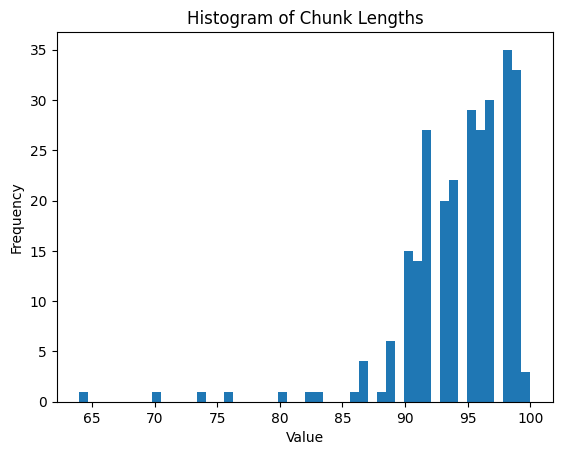

In [7]:
len_every_resume_chunk = [len(chunk.page_content) for chunk in resume_chunks]
plot_histogram_of_chunk_length(len_every_resume_chunk, bins=50)

Part 3: [Embeddings](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) Generation and [Database](https://docs.trychroma.com/getting-started) storage

In [8]:
import chromadb
from chromadb.utils.embedding_functions import create_langchain_embedding
from langchain_huggingface import HuggingFaceEmbeddings

langchain_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

ef = create_langchain_embedding(langchain_embeddings)
client = chromadb.PersistentClient(path="./chroma-data")
collection = client.get_or_create_collection(name="resume_collection", embedding_function=ef)

documents, ids, metadatas = [], [], []
for id, chunk in enumerate(resume_chunks):
    ids.append(str(id+1))
    documents.append(chunk.page_content)
    metadatas.append(chunk.metadata)

collection.add(ids=ids,documents=documents, metadatas=metadatas)

/home/harsha/code/bmw-tata-jv/civiliser/civiliser_venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Part 4: Skills Extraction from LLM

In [9]:
from dotenv import load_dotenv
load_dotenv()

OPEN_API_KEY = os.environ.get("OPENAI_API_KEY")

In [10]:
from prompt import PROMPT
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template(PROMPT)

In [11]:
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain

llm = ChatOpenAI(model="gpt-4")

In [12]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

In [13]:
# Helper function to post-process LLM response

def string_to_list(s):
    """
    Convert a string representation of a list to an actual list.

    This function takes a string that represents a list (e.g., '[item1, item2, item3]') and converts it into an actual list of strings.
    The function removes the first and last characters (the brackets), splits the string into individual items using commas as delimiters,
    and removes any leading or trailing whitespaces from each item.

    Args:
        s (str): The input string to convert.

    Returns:
        list[str]: The converted list of strings.

    Examples:
        >>> string_to_list('[item1, item2, item3]')
        ['item1', 'item2', 'item3']
    """
    # Remove the first and last characters (the brackets)
    s = s[1:-1]
    # Split the string into a list using comma as delimiter
    # Also, remove any leading or trailing whitespaces from each item
    return [str(item.strip()) for item in s.split(',')]

In [14]:
chain = prompt_template | llm | parser
results_chain = chain.invoke({"job_description": jd_docs[0].page_content})
results = string_to_list(results_chain)
results

['Java', 'Python', 'Agile']

Part 5: Database Retrieval

In [15]:
collection.query(
    query_texts=results,
    n_results=3,
    include=["metadatas", "documents"]
)

{'ids': [['29', '50', '61'], ['49', '229', '257'], ['245', '244', '60']],
 'distances': None,
 'metadatas': [[{'page': 0,
    'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'}],
  [{'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-senior-python-dev.pdf'},
   {'page': 0, 'source': '../data/resumes/resume-software-engg.pdf'}]],
 'embeddings': None,
 'documents': [['system, increasing system tenfold  Developed user-friendly interfaces using J2EE and JavaScript',
   'IBM  SKILLS  Programming Languages: Python (Advanced), Java (Advanced), C++ (Intermediate),',
   'O